# HOBYS dr21

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/HOBYS/dr21/'
name = 'dr21'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [2]:
figfile = path + name + '_coldens_cf_r500_medsmo3.fits'

In [3]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

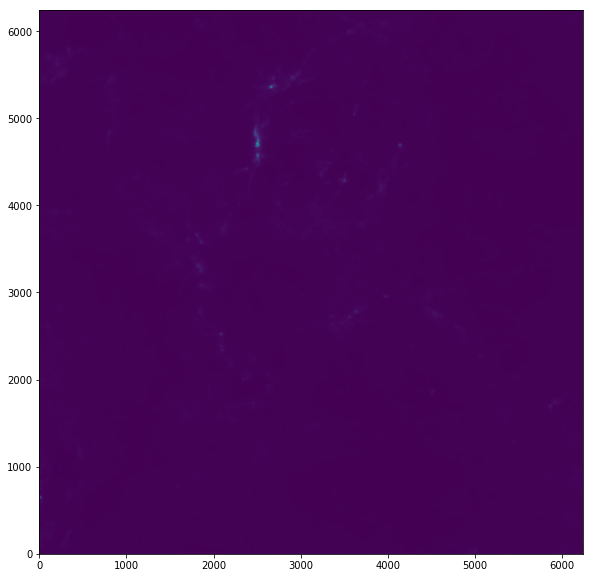

In [4]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

INFO: Auto-setting vmin to  4.326e+21 [aplpy.core]
INFO: Auto-setting vmax to  3.256e+22 [aplpy.core]


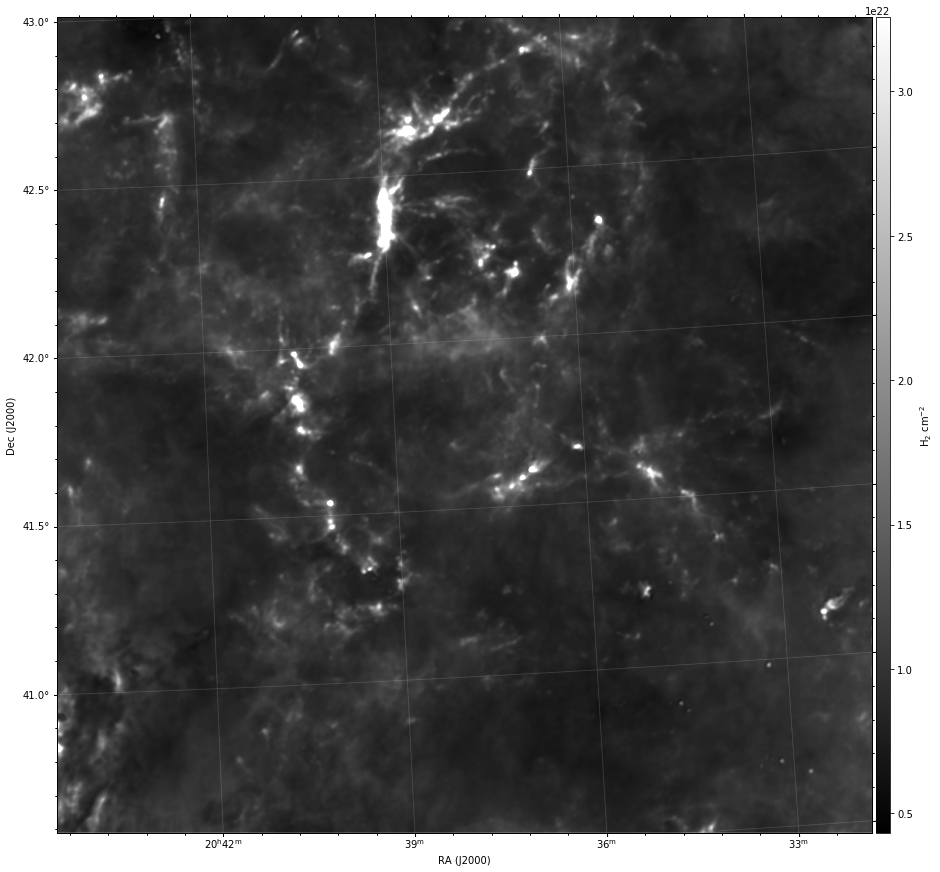

In [5]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + name + '_coldens_cf_r500_medsmo3.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [6]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6240                                                  
NAXIS2  =                 6240                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT Column density image at 500mu res. (medsmo3)                            
CREATOR = 'MODFITS '           / Alexander Men   shchikov, SAp IRFU CEA Saclay  
HEADER  = 'CygX    '           / title                                          
FOOTER1 = 'CygX    '           / part 1                                         
FOOTER2 = '        '           / part 2                                         
DATE    = '2017-11-30T21:52:

In [7]:
import reproject as proj

In [8]:
hdproj = header.copy()

ratio = 0.00388889/0.00038888888888889

#Change pixel resolution
hdproj['CDELT1'] = -0.00388889
hdproj['CDELT2'] = 0.00388889
hdproj['CRPIX1'] = header['CRPIX1']/ratio
hdproj['CRPIX2'] = header['CRPIX2']/ratio
hdproj['NAXIS1'] = np.int(header['NAXIS1']/ratio)
hdproj['NAXIS2'] = np.int(header['NAXIS2']/ratio)
del hdproj['CD1_1']
del hdproj['CD1_2']
del hdproj['CD2_1']
del hdproj['CD2_2'] 


improj = proj.reproject_exact(HDU,hdproj)
improjnp = np.asarray(improj)
fits.writeto(path + name + '_coldens_cf_r500_medsmo3_rebin_rot.fits',improjnp[0,:,:], hdproj, overwrite=True)

In [9]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

INFO: Auto-setting vmin to  4.609e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.923e+22 [aplpy.core]


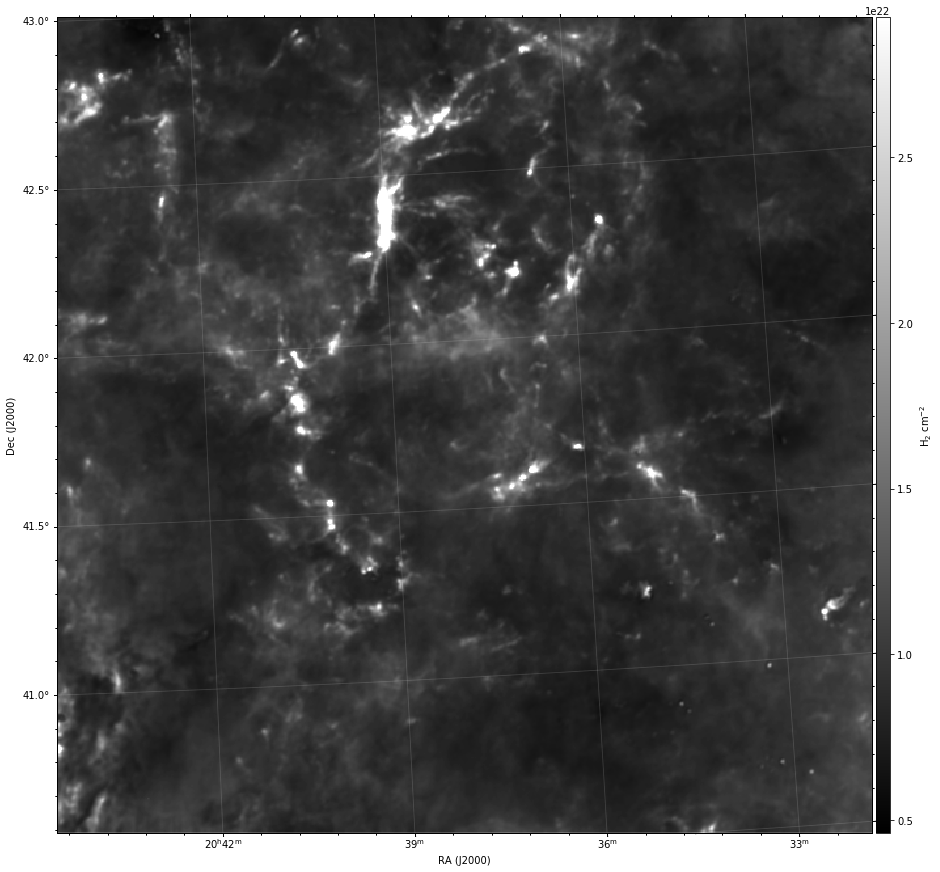

In [10]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + name + '_coldens_cf_r500_medsmo3_rebin_rot.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
#fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

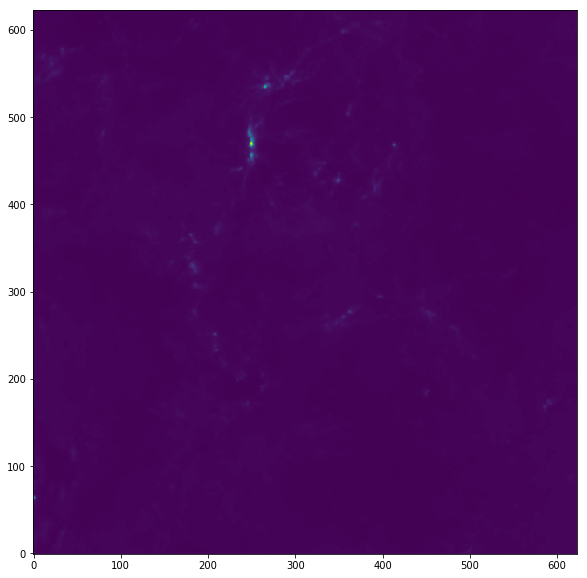

In [11]:
#Read map
HDU = fits.open(path + name + '_coldens_cf_r500_medsmo3_rebin_rot.fits')
im = HDU[0].data
header = HDU[0].header
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [12]:
print('Dimensions ', im.shape)

Dimensions  (623, 623)


In [13]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((750,750))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

In [14]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

750 750


Text(0.5, 1.0, 'Beam power spectrum')

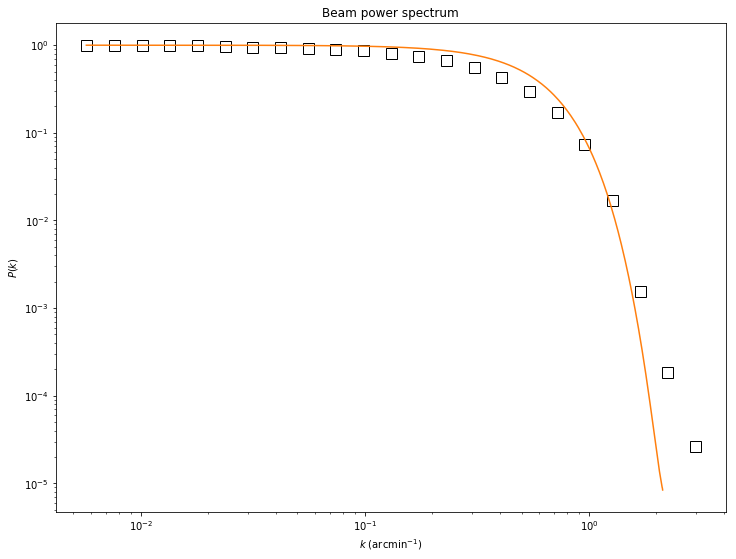

In [15]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[0],newdim[1],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Power law fit
Coherent wavelet
A, Gamma, P0 =  3.35681e+43 -1.43021 6.32114e+41
Gaussian wavelet
A, Gamma, P0 =  5.11616e+40 -2.85989 1.22888e+40


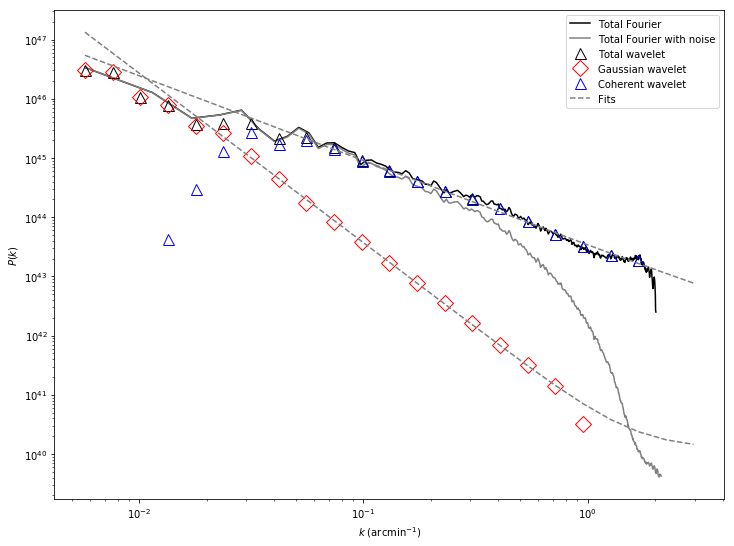

In [34]:
Noise=spec_k[-1]

#Power spectra fits
A_gauss, gamma_gauss, P0_gauss = 0.511616e+41, -2.85989, 0.122888e+41
fit_gauss=A_gauss*wav_k**gamma_gauss+P0_gauss
A_cohe, gamma_cohe, P0_cohe = 335.681e+41, -1.43021, 6.32114e+41
fit_cohe=A_cohe*wav_k**gamma_cohe+P0_cohe

print('Power law fit')
print('Coherent wavelet')
print('A, Gamma, P0 = ', A_cohe, gamma_cohe, P0_cohe)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', A_gauss, gamma_gauss, P0_gauss)


plt.figure(figsize(12,9))
plt.plot(tab_k[:-20], (spec_k[:-20]-Noise)/spec_beamn2[:-20], color='black',label=r'Total Fourier')
plt.plot(tab_k, spec_k, color='grey',label=r'Total Fourier with noise')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')

plt.plot(wav_k, fit_gauss, color='grey', ls='--', lw=1.5, label=r'Fits')
plt.plot(wav_k, fit_cohe, color='grey', ls='--', lw=1.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

In [17]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M+6,:,:].real,axis=0)
scale_free = np.sum(wt[2*M+6:3*M,:,:].real,axis=0)

fits.writeto(path + name + '_coldens_cf_r500_medsmo3_reconst_filaments.fits', filaments, header, overwrite=True)
fits.writeto(path + name + '_coldens_cf_r500_medsmo3_reconst_scale_free.fits', scale_free, header, overwrite=True)

INFO: Auto-setting vmin to -4.685e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.282e+22 [aplpy.core]
INFO: Auto-setting vmin to -1.769e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.259e+21 [aplpy.core]


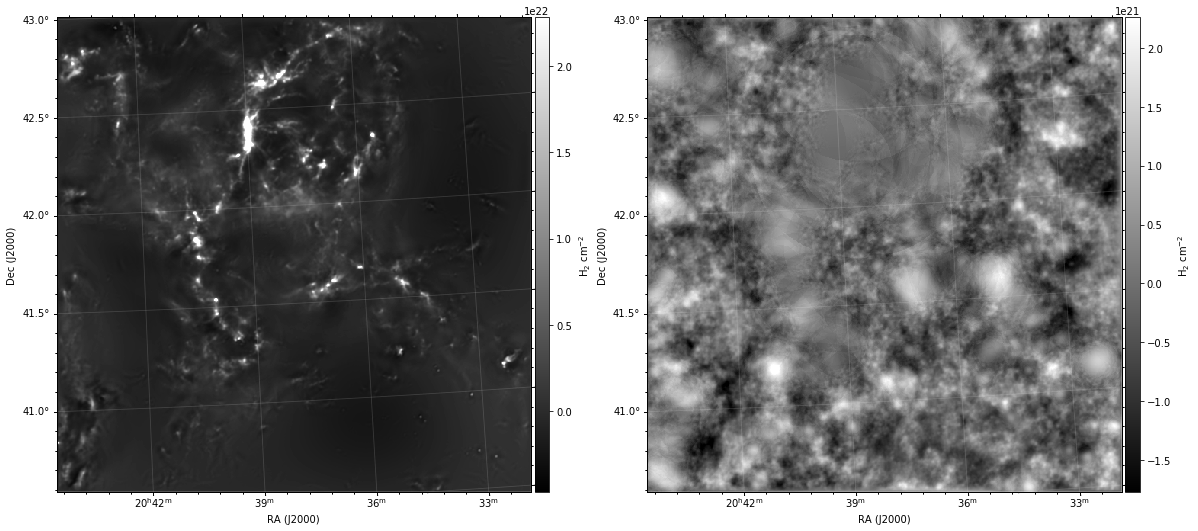

In [18]:
fig_all = plt.figure(1, figsize=(30,30))

fig = aplpy.FITSFigure(path + name + '_coldens_cf_r500_medsmo3_reconst_filaments.fits',figure=fig_all, subplot=(1,3,1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

fig = aplpy.FITSFigure(path + name + '_coldens_cf_r500_medsmo3_reconst_scale_free.fits',figure=fig_all, subplot=(1,3,2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')